In [2]:
import pickle
import io
import json
import functools
import time
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from itertools import islice
import urllib.parse

In [3]:
fname = "data/pickles/1706270670.pickle"
with open(fname, 'rb') as handle:
    qs = pickle.load(handle)

In [4]:
jsonData = qs.decode('utf8').replace("'", '"')
data = json.loads(jsonData)

In [5]:
dups = pd.read_csv("y2/duplicates.csv")

In [93]:
dups.head()

,ID,TAG,IV,USER_ID
0,UeU551H7FP4q7Z8jBLkXiu90Q3iiwCG94U7RrOKll8skCi...,kQWbg5J2SiuN8cmpO1Kw6A%253D%253D%250A,IJ%252BfGHZ0KV/uY0Rz%250A,2
1,q8qA1D%2BPDlOjhLfIpr/E8IVGXkoavUsIyAlrsaNNKtmC...,uSpUb7aATpoPvqHUw2yWWw%253D%253D%250A,buml3pAMEnHQf7HN%250A,522860
2,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,QGqhOZAD6imBZ0ijtxsdeQ%253D%253D%250A,hwyQdjHmNEg1gOfF%250A,516397
3,v1T09CkiMITOWuBy0nx7Cmz%2BHLgV4ajTFEsnYGfG5Tdj...,w7qPJXQ3XrysOE5SQYhnMg%253D%253D%250A,kLL0qUVEqK/kL1Xm%250A,512426
4,C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9CPwgWx10J...,bckg1il8vgqJ88xpYuEN2g%253D%253D%250A,ZcrW%252BvOquFOr4r8b%250A,512069


In [34]:
Counter(dups["USER_ID"])

Counter({523960: 17,
         837940: 13,
         1015780: 11,
         563724: 10,
         723646: 10,
         533047: 10,
         525760: 10,
         622625: 9,
         1001930: 9,
         769257: 9,
         211195: 8,
         668702: 8,
         586423: 8,
         658696: 8,
         761868: 8,
         883037: 8,
         775507: 8,
         661413: 7,
         750040: 7,
         491713: 7,
         795620: 7,
         520839: 7,
         897560: 7,
         991483: 7,
         529730: 6,
         763168: 6,
         552810: 6,
         591285: 6,
         524214: 6,
         60574: 6,
         718972: 6,
         792291: 6,
         824841: 6,
         783646: 6,
         494341: 6,
         876861: 6,
         593596: 6,
         589994: 6,
         527876: 5,
         513671: 5,
         905713: 5,
         294276: 5,
         902423: 5,
         653810: 5,
         875260: 5,
         948214: 5,
         542369: 5,
         567989: 5,
         618640: 5,
         505

In [ ]:
print(len(dups["ID"]), len(dups["USER_ID"]))

In [12]:
print(len(dups["USER_ID"]))
print(dups["ID"].nunique())

12828
12828


In [6]:
class Dataset:
    def __init__(self, data, doClean=True, **kwargs):
        self.rawData = data
        if doClean:
            self.clean()
        self.savePath = f'{fname.replace("pickle", "csv")}'
        
    def timer(func):
        @functools.wraps(func)
        def wrapper_timer(*args, **kwargs):
            tic = time.perf_counter()
            value = func(*args, **kwargs)
            toc = time.perf_counter()
            elapsed_time = toc - tic
            print(f"Completed in {elapsed_time:0.4f} seconds")
            return value
        return wrapper_timer
    
    @timer
    def loadcsv(self, dataType):
        if dataType == 'round' or dataType == "rounds":
            self.rounds = pd.read_csv(self.savePath)
        elif dataType == 'response' or dataType == "responses":
            self.responses = pd.read_csv(self.savePath.replace("round", "response"))
            
    @timer
    def loadDuplicates(self, path):
        # There are duplicates within our dataset - this loads in a mapping between common ID and hashed ID to find them
        # self.duplicates = pd.read_json('duplicates.json', orient="index")
        self.duplicates = pd.read_csv('y2/duplicates.csv')
        
    @timer
    def loadScores(self):
        # Load in the participant scores generaterd by Mira
        self.ranked = pd.read_csv("summary_completed_16_2_23.csv", index_col=0)
        
    @timer
    def filterDuplicates(self, opts=[]):
        """
        Take the loaded-in duplicates dataframe, and cycle through each of the IDs. If the user has any completes, take only the first
        let's also add a column to the round data indicating global attempt:
             - 0: Part of the user's very first and only attempt (not including same-ID restarts)
             - 1: The user's first attempt, complete or not, but they then attempt more
             - 2: Part of the user's 1st complete attempt, but not first global attempt
             - 3: Part of a complete attempt that isn't the user's first (i.e they've completed before)
             - 4: Part of an incomplete, not-first global attempt
        Any of these values included in opts will be removed from the dataset
        """
        if not isinstance(self.rounds, pd.DataFrame):
            self.rounds = pd.DataFrame.from_dict(self.rounds, orient='index')
            
        # Add new column to rounds dataset
        # Get a nested list of hashed IDs for each common ID
        nestedIds = [list(i[1]) for i in self.duplicates.iterrows()]
        # Get the equivalent list of PKs - PKs are made in series so we can find a time-ordering    
        duplicatePks = [sorted(Counter(list(self.rounds.loc[self.rounds["id"].isin(nestedIds[nestedIds.index(i)])]["pk"]))) for i in nestedIds]
        print(f"Obtained {len(duplicatePks)} duplicates")
        # Now go through each sub-group and each pk and find if complete or not - 
        # If it is, then log the pk, if not pass
        self.rounds["globalAttempt"] = [0 for _ in range(len(self.rounds["pk"]))]
        fad = []
        for i in duplicatePks:
            tmp = []
            for j in i:
                if True in list(self.rounds.loc[self.rounds["pk"] == j]["gameComplete"]):
                    # Complete attempt, set globalAttempt to either 1 or 2
                    if len(tmp) == 0:
                        gA = 1 # Their actual first complete attempt
                    else:
                        if True in tmp:
                            gA = 3 # This is complete, and they've previously completed
                        else:
                            gA = 2 # First complete, not first attempt
                    # Update
                    tmp.append(True)
                    fad.append(j)
                else:
                    gA = 4
                    tmp.append(False)
                # Assign global attempts to dataframe
                self.rounds.loc[self.rounds["pk"] == j, ["globalAttempt"]] = gA
                
        # And filter by removing all types we don't want from opts
        return self.rounds.loc[~self.rounds["globalAttempt"].isin(opts)]
        
        
    @timer
    def clean(self):
        self.cleanData = {}
        for user in self.rawData:
            tmp = {
                'pk' : user['id'],
                'userId' : urllib.parse.quote(user['userId']),
                'rawData' : json.loads(user['rawData']),
                'sdata' : None,
                'edata' : user['edata'],
                'parameters' : user['parameters'],
                'totalAttempts' : None,
                'completed' : user['completeAttempt'],
                'lastCompletedRound' : None,
                'lastTrialGame' : None,
                'finalRooms' : [],
                'userIP' : user['userIP'],
                'urlParameters' : user['urlParameters'],
                'timestamps' : [],
                'timeCreated' : user['timeCreated'],
                'lastModified' : user['lastModified']
            }
            # Check how many attempts the user has had
            tmp['totalAttempts'] = len(tmp['rawData'])
            # Store timestamp/s
            tmp['timestamps'] = list(tmp['rawData'].keys())
            # If it's one, check if it's complete
            if tmp['totalAttempts'] == 1:
                # Get the attempt timestamp
                timestamp = list(tmp['rawData'].keys())[0]
            elif tmp['totalAttempts'] > 1:
                # For multiple attempts, find the occurence with the highest number of completed trial_layouts
                indAttempts = [] # individual attempts
                for i in range(tmp['totalAttempts']):
                    # Get the sdata for this timestamp, and get the length of the expt_index array
                    try:
                        attNum = len(json.loads(tmp['rawData'][tmp['timestamps'][i]]['sdata'])['expt_index'])
                        indAttempts.append(attNum)
                    except:
                        indAttempts.append(0)
                # Get the index of the value with the greatest magnitude
                timestamp = tmp['timestamps'][np.argmax(indAttempts)]
                
            # Use the timestamp to add sdata to tmp
            try:
                tmp['sdata'] = json.loads(tmp['rawData'][timestamp]['sdata'])
            except:
                if tmp['rawData'][timestamp]['sdata'] == None or len(tmp['rawData'][timestamp]['sdata']) == 0:
                    tmp['sdata'] = None
            if tmp['sdata'] != None:
                # Check if complete by:
                #    - trial_layout == 92 or
                #    - trial_game == 80
                # if len(Counter(tmp['sdata']['trial_layout']).keys()) >= 92:
                if max(np.array(tmp['sdata']['trial_game'], dtype=np.float64)) >= 80:
                    tmp['completed'] = True
                    tmp['lastCompletedRound'] = len(tmp['sdata']['trial_game'])
                else:
                    tmp['completed'] = False
                    tmp['lastCompletedRound'] = len(Counter(tmp['sdata']['trial_layout']).keys())
                # Store how many trial_games they've seen
                tmp['lastTrialGame'] = int(tmp['sdata']['trial_game'][-1])
            else:
                tmp['completed'] = False
                tmp['lastCompletedRound'] = 0
                
            self.cleanData[tmp['pk']] = tmp
        print("Dataset ready.")
            
    @timer
    def count(self, verbose=False):
        self.numParticipants = len(self.cleanData)
        cc = 0
        for user in self.cleanData:
            if self.cleanData[user]['completed']:
                cc += 1
        self.numCompleted = cc
        if verbose:
            print(f'{self.numCompleted} / {self.numParticipants} completed participants. Completion rate = {round(100*self.numCompleted/self.numParticipants, 2)}%')
         
        
    @timer
    def query(self, iD=None, pk=None):
        """
        Summary:
                - Query the clean data to extract specific participants by id or pk
        """
        
        # check if df instance
        if not isinstance(self.cleanData, pd.DataFrame):
            df = pd.DataFrame.from_dict(self.cleanData, orient='index')
        else:
            df = self.cleanData
        
        if iD is not None:
            return df.loc[df["id"] == iD]
        elif pk is not None:
             return df.loc[df["pk"] == pk]
            
        print("No match found.")
        return None
        
    def countFromRounds(self, verbose=False):
        # Get unique participant ids
        self.numParticipants = len(Counter(self.rounds["pk"]))
        onlyComplete = self.rounds.loc[self.rounds['gameComplete'] == True]
        self.numCompleted = onlyComplete['pk'].nunique()
        if verbose:
            print(f'{self.numCompleted} / {self.numParticipants} completed participants. Completion rate = {round(100*self.numCompleted/self.numParticipants, 2)}%')
        
    @timer
    def getRounds(self, asDf=True, doFilter=True):
        self.rounds = {}
        count = 0
        for user in self.cleanData:
            u = self.cleanData[user]
            us = u['sdata']
            if us is not None:
                for i in range(len(u['sdata']['expt_index'])):
                    self.rounds[str(count)] = {
                        "pk" : u['pk'],
                        "id" : u['userId'],
                        "iv" : None if (u['urlParameters'] is None or u['urlParameters']['iv'] == None) else urllib.parse.quote(u['urlParameters']['iv']),
                        "tag" : None if (u['urlParameters'] is None or u['urlParameters']['tag'] == None) else urllib.parse.quote(u['urlParameters']['tag']),
                        "expt_index": us['expt_index'][i],
                        "expt_trial": us['expt_trial'][i],
                        "trial_layout" : us['trial_layout'][i],
                        "trial_level" : us['trial_level'][i],
                        "trial_solved" : us['trial_solved'][i],
                        "trial_attempts" : us['trial_attempts'][i],
                        "trial_game" : us['trial_game'][i],
                        "trial_transfer" : us['trial_transfer'][i],
                        "trial_test" : us['trial_test'][i],
                        "round_start_time" : None,
                        "round_end_time" : None,
                        "last_room" : None,
                        "roundAttempted" : None,
                        "gameComplete" : u["completed"],
                    }

                    # Insert start time, end time, and roundAttempted
                    if len(us["resp"][str(i)]["timestamp"]) != 0:
                        # If an attempt has been made
                        self.rounds[str(count)]["round_start_time"] = us["resp"][str(i)]["timestamp"][0] - us["resp"][str(i)]["reactiontime"][0]
                        self.rounds[str(count)]["round_end_time"] = us["resp"][str(i)]["timestamp"][-1]
                        self.rounds[str(count)]["roundAttempted"] = True
                    else:
                        self.rounds[str(count)]["roundAttempted"] = False
                        
                    # Compute final room position as [x, y]. Scale is 0->10 and includes 2 walls
                    if len(us["resp"][str(i)]["xloc"]) != 0 and len(us["resp"][str(i)]["yloc"]) != 0:
                        xloc = us["resp"][str(i)]["xloc"][-1]
                        yloc = us["resp"][str(i)]["yloc"][-1]
                        self.rounds[str(count)]["last_room"] = []
                        if xloc < 3:
                            self.rounds[str(count)]["last_room"].append(0)
                        elif 3 < xloc < 7:
                            self.rounds[str(count)]["last_room"].append(1)
                        elif 7 < xloc < 11:
                            self.rounds[str(count)]["last_room"].append(2)
                        if yloc < 3:
                            self.rounds[str(count)]["last_room"].append(0)
                        elif 3 < yloc < 7:
                            self.rounds[str(count)]["last_room"].append(1)
                        elif 7 < yloc < 11:
                            self.rounds[str(count)]["last_room"].append(2)
                        self.rounds[str(count)]["last_room"] = str(self.rounds[str(count)]["last_room"]).replace(",", "-")

                    # Increase round count
                    count += 1
        if asDf:       
            # Store as dataframe
            self.rounds = pd.DataFrame.from_dict(self.rounds, orient="index")
            
        if doFilter:
            # Filter the data to remove duplicate participants, incompletes, and multiple-completes
            self.loadDuplicates("duplicates.json")
            self.filteredRounds = self.filterDuplicates([1, 2, 3, 4])
            self.completeRounds = self.filteredRounds.loc[self.filteredRounds["gameComplete"] == True]

        return None
        
    @timer
    def getResponses(self, asDf=True, doFilter=True):
        count = 0
        self.responses = {}
        for game in self.cleanData:
            # Get responses dict, containing responses for each round
            if self.cleanData[game]['sdata'] != None:
                resp = self.cleanData[game]['sdata']['resp'] # Check for Nonetype
                for r in resp:
                    # Iterate over each move in the round r
                    for move in range(len(resp[r]['timestamp'])):
                        self.responses[count] = {
                            "id" : self.cleanData[game]['userId'],
                            "pk" : self.cleanData[game]['pk'],
                            "round" : self.cleanData[game]['sdata']['expt_index'][int(r)],
                            "level" : self.cleanData[game]['sdata']['trial_level'][int(r)],
                            "layout" : self.cleanData[game]['sdata']['trial_layout'][int(r)],
                            "timestamp" : resp[r]['timestamp'][move],
                            "reactiontime" : resp[r]['reactiontime'][move],
                            "direction" : resp[r]['direction'][move],
                            "allowed" : resp[r]['allowed'][move],
                            "tool" : resp[r]['tool'][move],
                            "xloc" : resp[r]['xloc'][move],
                            "yloc" : resp[r]['yloc'][move],
                            "gameComplete" : self.cleanData[game]["completed"],
                            "roundSolved" : self.cleanData[game]['sdata']['trial_solved'][int(r)],
                        }
                        count += 1
                        
        self.responses = pd.DataFrame.from_dict(self.responses, orient="index")
        if doFilter:
            # Get a list of all the IDs in self.filteredRounds and remove any from self.responses not in this list
            cleanIDs = self.completeRounds['id']
            cleanIDs_incomplete = self.filteredRounds['id']
            clean = list(Counter(cleanIDs).keys())
            clean_incomplete = list(Counter(cleanIDs_incomplete).keys())
            # Iterate through dataset.responses and remove any not in this list
            self.filteredResponses = self.responses.loc[self.responses['id'].isin(clean_incomplete)]
            self.completeResponses = self.responses.loc[self.responses['id'].isin(clean)]
            return None
        
        return None
    
    @timer
    def getResponseBatch(self, n=10, save=False):
        """
        Summary:
                - Sample batch of response data from dataframe
        Inputs:
                - n: number of participants to sample all responses for
                - save: boolean, to save file to disk
        """
        # Get list of UIDs
        uid = list(Counter(self.completeResponses["pk"]))
        # Randomly sample the participant IDs
        pkBatch = random.sample(uid, n)
        # Filter df by chosen IDs
        self.batch = self.completeResponses.loc[self.completeResponses['pk'].isin(pkBatch)]
        if save:
            self.batch.to_csv(self.savePath.replace(".", "_batch."))
        return self.batch
    
    @timer
    def getRooms(self):
        """
        Summary:
            - Return the data on a room-by-room level mapping, where each row represents information about the room 
            -    the player is in at time t_n
        """
        
        assert self.responses is not None, "Must have initialised response-level dict before filtering to rooms. Please run dataset.getResponses()"
        
    
    @timer
    def save(self, name, batchSize=None):
        if name == "round":
            try:
                if batchSize == None:
                    df.to_csv(self.savePath)
                    print(f'File saved to disk at {self.savePath}')
                else:
                    # Do a batching process to split the CSVs - break up in groups of 1000 pk
                    # list(islice(dataset.rounds.items(), 100, 200))
                    start = 0
                    bS = batchSize
                    numBatches = len(self.rounds)//1000
                    remainder = len(self.rounds)%1000
                    sumTotal = 0
                    for N in range(numBatches+1):
                        print(f'Saving batch {start} -> {start+bS}')
                        batchDict = dict(islice(self.rounds.items(), start, start+bS))
                        start += bS
                        sumTotal += len(batchDict)
                        # Convert to df and save as csv
                        pd.DataFrame.from_dict(batchDict, orient='index').to_csv(f'riseUploads/round/rounds_batch_{N}.csv', index=False)
                    print(f'Saved {numBatches}, total rounds {sumTotal}/{len(self.rounds)}')
            except:
                raise Exception("An error occurred. Did you remember to run self.getRounds()?")
            
        elif name == "response":
            try:
                if batchSize == None:
                    df.to_csv(self.savePath)
                    print(f'File saved to disk at {self.savePath}')
                else:
                    start = 0
                    bS = batchSize
                    numBatches = len(self.responses)//1000
                    remainder = len(self.responses)%1000
                    sumTotal = 0
                    for N in range(numBatches+1):
                        batchDict = dict(islice(self.responses.items(), start, start+bS))
                        start += bS
                        sumTotal += len(batchDict)
                        # Convert to df and save as csv
                        pd.DataFrame.from_dict(batchDict, orient='index').to_csv(f'riseUploads/response/responses_batch_{N}.csv', index=False)
                    print(f'Saved {numBatches}, total rounds {sumTotal}/{len(self.responses)}')
            except:
                raise Exception("An error occurred. Did you remember to run self.getRounds()?")
        else:
            raise Exception("Name must be dict of type round of response")
            
    ## Data Tests
    
    @timer
    def individualHasCompleted(self, verbose=True):
        """
        Summary:
                - Randomly pick an individual and check if the flag for completed matches the data
                - Printout data for Human examination
        """
        
        # if self.rounds isn't a dataframe, then convert it
        if not isinstance(self.rounds, pd.DataFrame):
            self.rounds = pd.DataFrame.from_dict(self.rounds, orient='index')
        
        # Pick random individual from cleanData
        pt = random.sample(list(self.rounds["pk"]), 1)
        
        # Get their completion status
        
        # Filter self.rounds dataframe for this participant
        ptdf = self.rounds.loc[self.rounds["pk"].isin(pt)]
        
        # Run tail to examine the final rounds they completed
        if verbose:
            print(f'Participant {list(ptdf["pk"])[0]} has completion status: {list(ptdf["gameComplete"])[0]}')
            print(f'They played {len(list(ptdf["expt_index"])[-1])} total rounds, and {len(Counter(list(ptdf["trial_layout"])))} were unique')
            print("Their first 5 and last 5 trials were:")
            ptdf.head(5)
            ptdf.tail(5)
            
        return ptdf

In [16]:
class Layouts:
    def loadLayouts(self, layouts):
        # Convert a list of layout names into a dict of numpy arrays containing layout information
        self.layouts = {}
        for l in layouts:
            if l != None and l != 'None':
                tmp = []
                f = open(f'layout/{l}.txt', "r")
                for i in f.readlines():
                    tmp.append(i.replace(' ', '').replace('\n', '').split(','))
                self.layouts[l] = np.asarray(tmp)
                f.close()
                
    def path(self, path, layout, directions=[]):
        # Overlay provided participant's path on the room layout
        mapping = {
            'u' : '↑',
            'd' : '↓',
            'l' : '←',
            'r' : '→',
            'f' : 'o'
        }
        try:
            lyt = self.layouts
        except:
            raise Exception("self.layouts not found. Have you loaded in your layouts using self.layouts()?")
            
        for ix, p in enumerate(path):
            if lyt[layout][p[0]][p[1]] == '':
                if directions != []:
                    lyt[layout][p[0]][p[1]] = mapping[directions[ix]]
                else:
                    lyt[layout][p[0]][p[1]] = 'o'
                
        print(lyt[layout])

In [220]:
def filterDuplicates(cleanData, duplicates):
    # Clean data is datasets.cleanData as a dataframe
    # duplicates is a csv file of duplicates straight from snowflake loaded as a dataframe
    """
    Take the loaded-in duplicates dataframe, and cycle through each of the IDs. If the user has any completes, take only the first
    let's also add a column to the round data indicating global attempt:
            - 0: Part of the user's very first and only attempt (not including same-ID restarts)
            - 1: The user's first attempt, complete or not, but they then attempt more
            - 2: Part of the user's 1st complete attempt, but not first global attempt
            - 3: Part of a complete attempt that isn't the user's first (i.e they've completed before)
            - 4: Part of an incomplete, not-first global attempt
    Any of these values included in opts will be removed from the dataset
    """
    # Make a dataframe that only has duplicated IDs in
    countedDict = Counter(duplicates["USER_ID"])
    duplicateIDs = [i for i in countedDict if countedDict[i] >= 2]
    # Create groups of duplicate IDs used per person
    duplicateHashedIDs = []
    for id in duplicateIDs:
        tmp = duplicates.loc[duplicates["USER_ID"] == id]["ID"]
        duplicateHashedIDs.append(list(tmp))

    # Get the IDs associated with the first attempt for each set of duplicates
    firstAttempts = []
    notFirstAttempts = []
    for individual in duplicateHashedIDs:
        # Get each attempt from the IDS (2 or 3 at a time typically) and find only the earliest timestamped one
        repeats = cleanData.loc[cleanData["userId"].isin(individual)]
        # Get the index of the smallest - i.e. earliest in epoch time - timestamp
        firstTimestamp = np.argmin([int(i[0]) for i in list(repeats["timestamps"])])
        # Add the ID associated with the first attempt to the list
        firstAttempts.append(individual[firstTimestamp])
        # also store the repeats
        [notFirstAttempts.append(i) for i in individual if i != individual[firstTimestamp]]

    # Create a dataframe of the cleanData, with only the first gameplay attempts, and remove the rest
    filteredCleanData = cleanData.loc[~cleanData["userId"].isin(notFirstAttempts)]
    
    return filteredCleanData
    

DataFrames
---

The following dataframes are contained within the dataset class:
- dataset.rawData: The absolute raw data, as JSON, from the server
- dataset.cleanData: A structured version of rawData with completes processed
- dataset.rounds: Complete round-level data, including duplicates and incompletes
- dataset.responses: Complete response-level data, including duplicates and incompletes
- dataset.duplicates: The duplicate participants that used multiple RISE IDs
- dataset.filteredRounds: Round-level data filtered to remove duplicates. Contains incompletes.
- dataset.completeRounds: Round-level data filtered to remove duplicates and incompletes. [Optimal Set]
- dataset.filteredResponses: Response-level data filtered to remove duplicates
- dataset.completeResponses: Response-level data filtered to remove duplicates and incompletes [Optimal Set]
- dataset.ranked: The scores generated by Mira

In [225]:
# ---- Load the dataset ----
dataset = Dataset(data) 

Dataset ready.
Completed in 96.4737 seconds


In [226]:
for i in dataset.cleanData:
    print(i)
    break

19302


In [228]:
dups = pd.read_csv("y2/duplicates.csv")
cleanData = pd.DataFrame.from_dict(dataset.cleanData, orient="index")
filteredCleanData = filterDuplicates(cleanData, dups)

In [236]:
# needs to be a dict, so convert from dataframe to dict
dataset.cleanData = pd.DataFrame.to_dict(filteredCleanData, orient="index")

In [237]:
dataset.getRounds(asDf=True, doFilter=False)

Completed in 31.0782 seconds


In [247]:
completeRounds = dataset.rounds.loc[dataset.rounds["gameComplete"] == True]

In [255]:
completeRounds.to_csv("rounds_complete_2024.csv", index=False)

In [252]:
incompleteRounds = dataset.rounds.loc[dataset.rounds["gameComplete"] == False]

In [256]:
incompleteRounds.to_csv("rounds_incomplete_2024.csv", index=False)

In [258]:
incompleteRounds["id"].nunique()

4451

In [224]:
dataset.cleanData

,pk,userId,rawData,sdata,edata,parameters,totalAttempts,completed,lastCompletedRound,lastTrialGame,finalRooms,userIP,urlParameters,timestamps,timeCreated,lastModified
19302,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,"{'1695134359421': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,True,105,80.0,[],180.191.102.159,{'id': 'PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGE...,[1695134359421],2023-09-19T14:37:38.678000Z,2023-09-19T15:01:56.317000Z
19303,19303,v1T09CkiMITOWuBy0nx7Cmz%2BHLgV4ajTFEsnYGfG5Tdj...,"{'1695137690496': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1], 'expt_trial': [1, 2], '...",None,None,1,False,2,2.0,[],83.99.11.200,{'id': 'v1T09CkiMITOWuBy0nx7Cmz%2BHLgV4ajTFEsn...,[1695137690496],2023-09-19T15:33:24.608000Z,2023-09-19T15:33:31.158000Z
19304,19304,C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9CPwgWx10J...,"{'1695163791354': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,True,111,80.0,[],105.112.70.83,{'id': 'C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9C...,[1695163791354],2023-09-19T22:50:31.279000Z,2023-09-20T20:48:25.790000Z
19305,19305,k0SIT8BByED9vtJ6UxrKYCnugyr4fPmlk8IteUjaKpOCq8...,"{'1695166842170': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,False,11,10.0,[],98.42.123.240,{'id': 'k0SIT8BByED9vtJ6UxrKYCnugyr4fPmlk8IteU...,[1695166842170],2023-09-19T23:39:39.393000Z,2023-09-19T23:45:35.503000Z
19306,19306,Wcb3b7vOoyJy1BQq5UsrZN1cz84M9v4M49Fln/CvMRQEDl...,"{'1695168647326': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7], 'expt...",None,None,1,False,8,7.0,[],102.67.9.207,{'id': 'Wcb3b7vOoyJy1BQq5UsrZN1cz84M9v4M49Fln/...,[1695168647326],2023-09-20T00:09:11.586000Z,2023-09-20T00:10:30.042000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32134,32134,kyVpq4kL8nlkYTWW6/CCVYBBrRFucxf39bTs/JeB6xIgUc...,"{'1705511409607': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,True,104,80.0,[],200.68.187.240,{'id': 'kyVpq4kL8nlkYTWW6/CCVYBBrRFucxf39bTs/J...,[1705511409607],2024-01-17T17:08:00.002000Z,2024-01-17T17:46:53.276000Z
32135,32135,CY2MuURfxJcU89uuYnBEqsGqne6t1YpFAxZEvt31uvgn9A...,"{'1705511456406': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,True,110,80.0,[],108.180.36.59,{'id': 'CY2MuURfxJcU89uuYnBEqsGqne6t1YpFAxZEvt...,[1705511456406],2024-01-17T17:08:36.966000Z,2024-01-17T17:37:15.125000Z
32136,32136,ya2B8B7K/7dNMUP/m4BW8AbUQIwm40V%2B4GW2N1fnv/iB...,"{'1705518838081': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,False,23,20.0,[],38.25.16.213,{'id': 'ya2B8B7K/7dNMUP/m4BW8AbUQIwm40V%2B4GW2...,[1705518838081],2024-01-17T19:12:05.169000Z,2024-01-17T23:45:50.938000Z
32137,32137,i7BEOZ3h3MOuGky27Qco7ZHCmg8Nj030gIBC9kSQ1kYvIy...,"{'1705518851383': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,False,93,80.0,[],70.167.188.90,{'id': 'i7BEOZ3h3MOuGky27Qco7ZHCmg8Nj030gIBC9k...,[1705518851383],2024-01-17T19:20:44.539000Z,2024-01-17T20:51:29.236000Z


In [218]:
cleanData = pd.DataFrame.from_dict(dataset.cleanData, orient="index")
# cleanData.head()

TypeError: 'numpy.ndarray' object is not callable

In [58]:
# ---- Process all data ----
dataset.getRounds(asDf=True, doFilter=True)
# dataset.getResponses(asDf=False, doFilter=True)

Completed in 0.0779 seconds
Obtained 12828 duplicates
Completed in 266.2762 seconds
Completed in 298.7032 seconds


In [76]:
countedDict = Counter(dups["USER_ID"])
dupIDs = [i for i in countedDict if countedDict[i] >= 2]

In [98]:
duplicateHashedIDs = []
for id in dupIDs:
    tmp = dups.loc[dups["USER_ID"] == id]["ID"]
    duplicateHashedIDs.append(list(tmp))

In [106]:
duplicateHashedIDs

[['Wcb3b7vOoyJy1BQq5UsrZN1cz84M9v4M49Fln/CvMRQEDlsVvE5/wA%3D%3D%0A',
  'QFYSMr1iMCZJ9edVQ6PlwVcw95F7b5pDIAbWzMogKBabDNRS5O3ZMQ%3D%3D%0A'],
 ['pVVWSjG7/q3eBbTRax5NuagOBHP%2B3XJI41bpZGucWF8fs9S3Jp/V1Ovf0ArN%0AKaUyzDm/xI3vtQY%3D%0A',
  'V3IeznwETzV4X9jEGQ2gg1%2BFSeedgbGmGNjF5WCsERhBnsWHc4%2BvvcGJ1wKr%0AcjAggSxOzEcZiOM%3D%0A'],
 ['slFkLPe8Afu6FDu5mBu2rhrgyVaqFu4T%2BD/xvJjVH%2BzzHqc%3D%0A',
  'Uw%2B/vXdVi6%2BXgaicqoffAObjyJx0tkUOW3KCqPVv4m7uNdk%3D%0A'],
 ['gV6mzbkot8xCASWgxxw7CCpoQdPuJVb059rcOHehtPU3AA%3D%3D%0A',
  'WMXoiN61Bh8BHivV4XiLXvdDDYeeSsds5mONFiZ1HkVNZQ%3D%3D%0A'],
 ['w9nDzjq7gcSpJC6MbgoDg6BQn%2BwhRO05Prh9qN8GvaHMnjeRDT/jzyzM%0A',
  'RltpMMIpPXRt8kA0eZD7PoDbV/oTdgzrOpEY5Q%2BT02fKvIs9mfsfrLOX%0A',
  'gI83MLssuNSvKSxlWwlHaNksvOAE0vLUjW1TpCNxzTtmoZPjMIxWA/ct%0A'],
 ['KsycSderFKUyL70Q80rAayMJWViPhMpZzMSWuQpK7pzaLQEsNOqx8I0u%0A',
  'V6G65nXgOsa0z2nrSklaqn/kAs9iWgICLPXA70pzLX0X/BWoJirmja8O%0A'],
 ['qLvsxpwhg8kMtobx1OF9h%2BLslPbQGxORap6zGpqAZuLTW0Wbfgw%3D%0A',
  'r8D%2BR7YAutJn0nLhZZTrCWC

In [195]:
firstAttempts = []
notFirstAttempts = []
for individual in duplicateHashedIDs:
    # Get each attempt from the IDS (2 or 3 at a time typically) and find only the earliest timestamped one
    repeats = cleanData.loc[cleanData["userId"].isin(individual)]
    # Get the index of the smallest - i.e. earliest in epoch time - timestamp
    firstTimestamp = np.argmin([int(i[0]) for i in list(repeats["timestamps"])])
    # Add the ID associated with the first attempt to the list
    firstAttempts.append(individual[firstTimestamp])
    [notFirstAttempts.append(i) for i in individual if i != individual[firstTimestamp]]

filteredCleanData = cleanData.loc[~cleanData["userId"].isin(notFirstAttempts)]

In [196]:
len(notFirstAttempts) + len(firstAttempts)

4465

In [201]:
dups["ID"].nunique()

12828

In [202]:
dups["ID"].nunique() - len(filteredCleanData)

2700

In [191]:
filteredCleanData

,pk,userId,rawData,sdata,edata,parameters,totalAttempts,completed,lastCompletedRound,lastTrialGame,finalRooms,userIP,urlParameters,timestamps,timeCreated,lastModified
19302,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,"{'1695134359421': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,True,105,80.0,[],180.191.102.159,{'id': 'PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGE...,[1695134359421],2023-09-19T14:37:38.678000Z,2023-09-19T15:01:56.317000Z
19303,19303,v1T09CkiMITOWuBy0nx7Cmz%2BHLgV4ajTFEsnYGfG5Tdj...,"{'1695137690496': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1], 'expt_trial': [1, 2], '...",None,None,1,False,2,2.0,[],83.99.11.200,{'id': 'v1T09CkiMITOWuBy0nx7Cmz%2BHLgV4ajTFEsn...,[1695137690496],2023-09-19T15:33:24.608000Z,2023-09-19T15:33:31.158000Z
19304,19304,C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9CPwgWx10J...,"{'1695163791354': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,True,111,80.0,[],105.112.70.83,{'id': 'C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9C...,[1695163791354],2023-09-19T22:50:31.279000Z,2023-09-20T20:48:25.790000Z
19305,19305,k0SIT8BByED9vtJ6UxrKYCnugyr4fPmlk8IteUjaKpOCq8...,"{'1695166842170': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,False,11,10.0,[],98.42.123.240,{'id': 'k0SIT8BByED9vtJ6UxrKYCnugyr4fPmlk8IteU...,[1695166842170],2023-09-19T23:39:39.393000Z,2023-09-19T23:45:35.503000Z
19306,19306,Wcb3b7vOoyJy1BQq5UsrZN1cz84M9v4M49Fln/CvMRQEDl...,"{'1695168647326': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7], 'expt...",None,None,1,False,8,7.0,[],102.67.9.207,{'id': 'Wcb3b7vOoyJy1BQq5UsrZN1cz84M9v4M49Fln/...,[1695168647326],2023-09-20T00:09:11.586000Z,2023-09-20T00:10:30.042000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32134,32134,kyVpq4kL8nlkYTWW6/CCVYBBrRFucxf39bTs/JeB6xIgUc...,"{'1705511409607': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,True,104,80.0,[],200.68.187.240,{'id': 'kyVpq4kL8nlkYTWW6/CCVYBBrRFucxf39bTs/J...,[1705511409607],2024-01-17T17:08:00.002000Z,2024-01-17T17:46:53.276000Z
32135,32135,CY2MuURfxJcU89uuYnBEqsGqne6t1YpFAxZEvt31uvgn9A...,"{'1705511456406': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,True,110,80.0,[],108.180.36.59,{'id': 'CY2MuURfxJcU89uuYnBEqsGqne6t1YpFAxZEvt...,[1705511456406],2024-01-17T17:08:36.966000Z,2024-01-17T17:37:15.125000Z
32136,32136,ya2B8B7K/7dNMUP/m4BW8AbUQIwm40V%2B4GW2N1fnv/iB...,"{'1705518838081': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,False,23,20.0,[],38.25.16.213,{'id': 'ya2B8B7K/7dNMUP/m4BW8AbUQIwm40V%2B4GW2...,[1705518838081],2024-01-17T19:12:05.169000Z,2024-01-17T23:45:50.938000Z
32137,32137,i7BEOZ3h3MOuGky27Qco7ZHCmg8Nj030gIBC9kSQ1kYvIy...,"{'1705518851383': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,False,93,80.0,[],70.167.188.90,{'id': 'i7BEOZ3h3MOuGky27Qco7ZHCmg8Nj030gIBC9k...,[1705518851383],2024-01-17T19:20:44.539000Z,2024-01-17T20:51:29.236000Z


In [136]:
list(repeats["timestamps"])

[['1695168647326'], ['1704917323971']]

In [145]:
m = min([int(i[0]) for i in list(repeats["timestamps"])])

1695168647326

In [156]:
repeats.loc[repeats["timestamps"].isin([m])]

,pk,userId,rawData,sdata,edata,parameters,totalAttempts,completed,lastCompletedRound,lastTrialGame,finalRooms,userIP,urlParameters,timestamps,timeCreated,lastModified


In [158]:
repeats

,pk,userId,rawData,sdata,edata,parameters,totalAttempts,completed,lastCompletedRound,lastTrialGame,finalRooms,userIP,urlParameters,timestamps,timeCreated,lastModified
19306,19306,Wcb3b7vOoyJy1BQq5UsrZN1cz84M9v4M49Fln/CvMRQEDl...,"{'1695168647326': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7], 'expt...",None,None,1,False,8,7.0,[],102.67.9.207,{'id': 'Wcb3b7vOoyJy1BQq5UsrZN1cz84M9v4M49Fln/...,[1695168647326],2023-09-20T00:09:11.586000Z,2023-09-20T00:10:30.042000Z
26785,26785,QFYSMr1iMCZJ9edVQ6PlwVcw95F7b5pDIAbWzMogKBabDN...,"{'1704917323971': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",None,None,1,False,17,15.0,[],102.89.33.106,{'id': 'QFYSMr1iMCZJ9edVQ6PlwVcw95F7b5pDIAbWzM...,[1704917323971],2024-01-10T20:06:40.662000Z,2024-01-10T20:10:41.728000Z


In [80]:
dups.loc[dups["USER_ID"].isin(dupIDs)]

,ID,TAG,IV,USER_ID
6,Wcb3b7vOoyJy1BQq5UsrZN1cz84M9v4M49Fln/CvMRQEDl...,vqbfcAIYFkSCyPA7qxjTjw%253D%253D%250A,51OMbAxeNNs%252BkZdW%250A,524670
11,pVVWSjG7/q3eBbTRax5NuagOBHP%2B3XJI41bpZGucWF8f...,vO3npzTOROfJqWBxvjcW6g%253D%253D%250A,IhMXkGJks9eGRNOU%250A,524749
12,V3IeznwETzV4X9jEGQ2gg1%2BFSeedgbGmGNjF5WCsERhB...,pByvpCMg%252BboA3rmOcpLM%252BA%253D%253D%250A,sDyGZV9iOXNmf0jY%250A,524749
13,slFkLPe8Afu6FDu5mBu2rhrgyVaqFu4T%2BD/xvJjVH%2B...,tpMzkiDzaTGD6isH9%252BC0rg%253D%253D%250A,KE7Pxsw2aT5%252BR54m%250A,522738
14,gV6mzbkot8xCASWgxxw7CCpoQdPuJVb059rcOHehtPU3AA...,bIcDPdZOF/pnCAsAcXRXsw%253D%253D%250A,Bb2D7NGo3grQWIAU%250A,524885
...,...,...,...,...
12817,KurXVSoBes1ZXTvdKVglEqX7NEFNgVkzfRBcR6XzXp60Xv...,D3C1%252B7MQJxDPKycNrEsexQ%253D%253D%250A,39BeIRSEHluCTIrb%250A,651998
12819,ZkEV5Ha3FZdTwUVdsSzazZzS6g/YiwVo5Z5JwZCWGLeGcT...,1oZCmkLeeY4NnL1FiqpIcg%253D%253D%250A,6So%252BA6s60eRnfiKT%250A,605401
12821,XhJ/oZGAjjx%2BxhwgTnS72Bizx7uXguJ2fNo0BBRJkJqG...,QaePAF8ayYkIN%252Bl0bBah0A%253D%253D%250A,u8T2eJeN3k5wEeji%250A,746307
12822,1Bp34aqX5Br6Y8UUL9I9uSxW75mvjCdEMYZ0mgQtQNA48D...,ZJWozpDWjV3b%252B8PYet2kSg%253D%253D%250A,1BBdTOas54rw68pY%250A,914703


In [ ]:
# Get the hashed ID equivalents of the true ID values in the duplicates list

In [55]:
Counter(dups["USER_ID"])[1005928]

2

In [38]:
Counter(dataset.rounds["globalAttempt"])

Counter({1: 702643, 4: 210598, 0: 190})

In [24]:
dataset.filteredRounds["id"].nunique()

2

In [32]:
dataset.rounds.to_csv('data/csvs/rounds_all_2324.csv')

In [25]:
dataset.completeRounds.nunique()
dataset.completeRounds.to_csv('rounds_complete_2324.csv')

In [45]:
dataset.filteredRounds.nunique()
dataset.filteredRounds.to_csv('rounds_incomplete.csv')

In [46]:
dataset.filteredResponses.nunique()
dataset.filteredResponses.to_csv('responses_incomplete.csv')

In [47]:
dataset.completeResponses.nunique()
dataset.completeResponses.to_csv('responses_complete.csv')

In [13]:
# We want to work with dataset.filteredResponses
dataset.filteredResponses.tail(25)

# Iterate over each participant
#uids = list(dataset.filteredResponses["pk"].unique())
#for uid in uids:
    # Get all layout

,id,pk,round,level,layout,timestamp,reactiontime,direction,allowed,tool,xloc,yloc,gameComplete,roundSolved
20597715,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,94,5.0,transfer_2,1675447997527,1.732,0.0,1.0,,2,10,True,0.0
20597716,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,94,5.0,transfer_2,1675447998311,0.784,2.0,1.0,t4,6,2,True,0.0
20597717,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,94,5.0,transfer_2,1675447998610,0.299,2.0,1.0,,6,1,True,0.0
20597718,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,94,5.0,transfer_2,1675447999694,1.084,0.0,1.0,,5,1,True,0.0
20597719,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,94,5.0,transfer_2,1675448000512,0.818,3.0,1.0,t1,9,1,True,0.0
20597720,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,94,5.0,transfer_2,1675448000830,0.318,3.0,1.0,,9,2,True,0.0
20597721,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,94,5.0,transfer_2,1675448001578,0.748,0.0,1.0,,8,2,True,0.0
20597722,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,95,5.0,transfer_11,1675448011304,4.665,0.0,1.0,,9,6,True,0.0
20597723,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,95,5.0,transfer_11,1675448011544,0.240,0.0,1.0,,8,6,True,0.0
20597724,sQFSYTcWS4Rx0T/zT4QVMzBokT7M5K%2Bjt4MXM3mbaKHG...,19296,96,5.0,transfer_17,1675448013582,1.139,1.0,1.0,c5,2,6,True,0.0


19296

Analysis
---

We could try breaking down the data into types per level - eg. level 1 catapult, teleporter, etc.
Then we can compare successes and failures per type, to see how people fail on each and when they make mistakes.

Following this we can increase the level and compare again, to see if there are common types that are harder than others (eg. is catapult consisently hardest, even after learning door etc.)

Catapult and door are 2-step processes, does the 2-step concept improve performance or does it not make a difference?

In [8]:
# Take a batch of response data - responses per round for completes games, for 10 participants
b = dataset.getResponseBatch(250);
b.nunique()

Completed in 2.0383 seconds


id                 250
pk                 250
round              169
level                5
layout            3778
timestamp       501808
reactiontime     16051
direction            4
allowed              2
tool                25
xloc                11
yloc                11
gameComplete         1
roundSolved          2
dtype: int64

In [9]:
b.to_csv('concepts/batch2.csv')

In [989]:
b = dataset.responses

Reduce the data into a format that only takes tool usage
===

Here we remove all responses between tools, and thus create a table with the following headers:
- id
- pk
- round: i.e. expt_index
- level: Difficulty
- layout: The name of the layout file, which can be opened using Layouts.layouts as a numpy array
- step: Which movement number (i.e. keypress or click) in the wider round this is
- reactionTime: The cumulative time up to this point
- tool: The tool type. First letter is one of ['k', 't', 'd', 'c']
- coords: The player coordinates that *resulted* from this step
- start: The round-start coords
- terminal: The round-end coords (i.e coords of goal)
- passed: Boolean of whether or not this round was overall successful
- path: The path taken from the previous tool (inc. start) to the current
- directions: The directions of movement as l-r-u-d, with f as NaN
- totalPath: The total path from start to finish for this round
- totalDirections: All directions of movement from start to finish for this round
- leadPathLength: The length of the path from the previous tool (inc. start) to this one
- numAllowed: The number of allowed movements from the previous lead path

In [10]:
# The formatting of this gives us lots of extra information, so we could do with reducing it to:
#    round, level, timestamp, startCoords, tool (includes start and end points), endRoom coords, wasSuccess

# Get all unique layouts from the response batch, and generate layouts matrices using the Layouts class
ll = Layouts()
ll.loadLayouts(list(Counter(b["layout"]).keys()))
# Map the 1-2-3-4 direction codes to strings
mapping = {'1.0' : 'r', '2.0' : 'u', '3.0' : 'd', '0.0' : 'l', 'NaN' : 'f', 'nan' : 'f'}
toolMapping = {'c' : 'catapult', 'd' : 'door', 'k' : 'key', 't' : 'teleporter'}
midData = []
midDataRow = []
# Iterate over the dataset, and add to the midData dict if we land on start, tool, or end
currentRound = 0
rTSum = 0 # Sum reaction time
step = 1
totalPath = []
totalDirections = []
path = []
directions = []
allowed = []
for ix, row in b.iterrows():
    # Reference the layout array
    if row['layout'] == None or row['layout'] == 'None':
        continue
    lyt = ll.layouts[row['layout']]
    rTSum += row['reactiontime']
    path.append([row["xloc"], row["yloc"]])
    directions.append(mapping[str(row["direction"])])
    totalPath.append([row["xloc"], row["yloc"]])
    totalDirections.append(mapping[str(row["direction"])])
    allowed.append(row["allowed"])
    if row['round'] != currentRound:
        rTSum = 0
        step = 1
        currentRound = row["round"]
        totalPath = []
        totalDirections = []
    if row['tool'] != '':
        # Compute if the round was successful or not by looking at the path and seeing if they hit the goal
        ss = np.where(lyt == 'i')
        ts = np.where(lyt == 'x')
        midData.append({
            "id" : row['id'],
            "pk" : row['pk'],
            "round" : row['round'],
            "level" : int(row['level']),
            "layout" : row["layout"],
            "step" : step,
            "reactionTime" : rTSum,
            "tool" : row["tool"],
            "toolType" : toolMapping[row["tool"][0]],
            "coords" : [row["xloc"], row["yloc"]],
            "start" : [ss[1][0], ss[0][0]],
            "terminal" : [ts[1][0], ts[0][0]],
            "passed" : row["roundSolved"],
            "path" : path,
            "directions" : directions,
            "totalPath" : totalPath,
            "totalDirections" : totalDirections,
            "leadPathLength" : len(path),
            "numAllowed" : len([i for i in allowed if i == 1.0])
        })
        path = []
        directions = []
        allowed = []
        
    step += 1
# To dataframe
mdf = pd.DataFrame.from_dict(midData)

In [11]:
mdf.head()

,id,pk,round,level,layout,step,reactionTime,tool,toolType,coords,start,terminal,passed,path,directions,totalPath,totalDirections,leadPathLength,numAllowed
0,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,1,1,r1_2_21,6,2.903,t3,teleporter,"[9, 9]","[2, 10]","[9, 10]",1.0,"[[2, 0], [2, 0], [2, 0], [2, 0], [2, 0], [2, 0...","[u, u, r, r, r, r, r, r, u, r, r, r, u, u, u, ...","[[2, 8], [2, 8], [2, 9], [1, 9], [9, 9], [9, 1...","[u, u, d, l, d, d, r]",19,6
1,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,2,1,r1_3_14,3,0.955,c2,catapult,"[6, 10]","[5, 8]","[9, 9]",0.0,"[[9, 10], [6, 8], [6, 9], [6, 10]]","[d, r, d, d]","[[6, 9], [6, 10], [6, 10], [6, 10], [6, 10], [...","[d, d, d, d, d, d, l, l, l, l, u, u, u, u, r, ...",4,4
2,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,3,1,r1_4_15,4,0.857,k4,key,"[6, 4]","[4, 5]","[8, 4]",1.0,"[[6, 10], [6, 10], [6, 10], [6, 10], [5, 10], ...","[d, d, d, d, l, l, l, l, u, u, u, u, r, r, r, ...","[[6, 5], [6, 5], [6, 4], [6, 5], [6, 6], [6, 5...","[r, r, u, d, d, u, r, r, u, d]",52,19
3,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,3,1,r1_4_15,8,4.146,d4,door,"[7, 5]","[4, 5]","[8, 4]",1.0,"[[6, 5], [6, 6], [6, 5], [7, 5]]","[d, d, u, r]","[[6, 5], [6, 5], [6, 4], [6, 5], [6, 6], [6, 5...","[r, r, u, d, d, u, r, r, u, d]",4,4
4,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,4,1,r1_5_22,3,0.701,c5,catapult,"[10, 2]","[8, 1]","[9, 4]",0.0,"[[8, 5], [8, 4], [8, 2], [9, 2], [10, 2]]","[r, u, d, r, r]","[[9, 2], [10, 2], [10, 2], [10, 2], [10, 2], [...","[r, r, r, r, r, d, r, r, r, d, d, d, u, u, u, ...",5,5


In [11]:
mdf.to_csv("concepts/batch2.csv")

In [12]:
ranked_df = pd.read_csv('ranked.csv')

In [13]:
ranked_df.tail(10)

,Unnamed: 0,ppt_id,train,test,transfer,score
8000,8001,nofSu7i1fU1upZ8HBi05jEhd1dI2dKZ0hybgO3RXPfmY%2...,0.0,0.0,0.0,-4.23991
8001,8002,nvzUmNMwhtfxPz5u590fj73dqx4G3NNA06KSftJudwrU5s...,0.0,0.0,0.0,-4.23991
8002,8003,OEJVMwu/MWwHCY0bIyxye6j9ICsVCXGwpIFcWsa8Gfpwcx...,0.0,0.0,0.0,-4.23991
8003,8004,oL%2B5OTg8e1NLloUXO5bZpxlp0bebCU%2BkS5TBi%2BfS...,0.0,0.0,0.0,-4.23991
8004,8005,p/q4mi9VcW7D5AX0FhTFqMYsEYL/NdntNmr5WQbiv9ur68...,0.0,0.0,0.0,-4.23991
8005,8006,sWg9QDfffvbu2nNbJcg1QTl14N8RCJNvXIAnZsqmESfYms...,0.0,0.0,0.0,-4.23991
8006,8007,X/tj64FNT/n5Qzeo4CIZ%2BLkBEjLF7hmRN6rq%2BbsZXM...,0.0,0.0,0.0,-4.23991
8007,8008,xR4zFOoihc/JDrqDGbErkwkBHgcf4xbvRDMyhrjl35645i...,0.0,0.0,0.0,-4.23991
8008,8009,ygZW57O4YfzVAGjx/bIjXN6gMHAn1oTu2zM2cwqirIyHpd...,0.0,0.0,0.0,-4.23991
8009,8010,Z0xm3XFigX/6D9XORBcNf%2ByifMK1FvmHyPP9pPC0LRq3...,0.0,0.0,0.0,-4.23991


In [14]:
mdf_Ids = [i for i in set(list(mdf.id))]
mdf_scores = []
for i in list(mdf['id']):
    score = list(ranked_df.loc[ranked_df['ppt_id'] == i]['score'])[0]
    mdf_scores.append(score)
mdf["score"] = mdf_scores
    

In [36]:
mdf.head(10)

,id,pk,round,level,layout,step,reactionTime,tool,toolType,coords,start,terminal,passed,path,directions,totalPath,totalDirections,leadPathLength,numAllowed,score
0,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,1,1,r1_2_21,6,2.903,t3,teleporter,"[9, 9]","[2, 10]","[9, 10]",1.0,"[[2, 0], [2, 0], [2, 0], [2, 0], [2, 0], [2, 0...","[u, u, r, r, r, r, r, r, u, r, r, r, u, u, u, ...","[[2, 8], [2, 8], [2, 9], [1, 9], [9, 9], [9, 1...","[u, u, d, l, d, d, r]",19,6,-1.66824
1,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,2,1,r1_3_14,3,0.955,c2,catapult,"[6, 10]","[5, 8]","[9, 9]",0.0,"[[9, 10], [6, 8], [6, 9], [6, 10]]","[d, r, d, d]","[[6, 9], [6, 10], [6, 10], [6, 10], [6, 10], [...","[d, d, d, d, d, d, l, l, l, l, u, u, u, u, r, ...",4,4,-1.66824
2,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,3,1,r1_4_15,4,0.857,k4,key,"[6, 4]","[4, 5]","[8, 4]",1.0,"[[6, 10], [6, 10], [6, 10], [6, 10], [5, 10], ...","[d, d, d, d, l, l, l, l, u, u, u, u, r, r, r, ...","[[6, 5], [6, 5], [6, 4], [6, 5], [6, 6], [6, 5...","[r, r, u, d, d, u, r, r, u, d]",52,19,-1.66824
3,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,3,1,r1_4_15,8,4.146,d4,door,"[7, 5]","[4, 5]","[8, 4]",1.0,"[[6, 5], [6, 6], [6, 5], [7, 5]]","[d, d, u, r]","[[6, 5], [6, 5], [6, 4], [6, 5], [6, 6], [6, 5...","[r, r, u, d, d, u, r, r, u, d]",4,4,-1.66824
4,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,4,1,r1_5_22,3,0.701,c5,catapult,"[10, 2]","[8, 1]","[9, 4]",0.0,"[[8, 5], [8, 4], [8, 2], [9, 2], [10, 2]]","[r, u, d, r, r]","[[9, 2], [10, 2], [10, 2], [10, 2], [10, 2], [...","[r, r, r, r, r, d, r, r, r, d, d, d, u, u, u, ...",5,5,-1.66824
5,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,5,1,test_10,5,1.286,c2,catapult,"[7, 0]","[4, 1]","[8, 8]",1.0,"[[10, 2], [10, 2], [10, 2], [10, 2], [10, 2], ...","[r, r, r, d, r, r, r, d, d, d, u, u, u, d, d, ...","[[5, 0], [5, 0], [5, 0], [7, 0], [8, 0], [8, 1...","[u, u, u, r, r, d, d, d, d, u, u, d, d, d, l, ...",21,7,-1.66824
6,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,5,1,test_10,8,3.735,t2,teleporter,"[10, 5]","[4, 1]","[8, 8]",1.0,"[[8, 0], [8, 1], [10, 5]]","[r, d, d]","[[5, 0], [5, 0], [5, 0], [7, 0], [8, 0], [8, 1...","[u, u, u, r, r, d, d, d, d, u, u, d, d, d, l, ...",3,3,-1.66824
7,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,5,1,test_10,12,5.811,k5,key,"[10, 4]","[4, 1]","[8, 8]",1.0,"[[10, 6], [10, 6], [10, 5], [10, 4]]","[d, d, u, u]","[[5, 0], [5, 0], [5, 0], [7, 0], [8, 0], [8, 1...","[u, u, u, r, r, d, d, d, d, u, u, d, d, d, l, ...",4,3,-1.66824
8,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,5,1,test_10,17,9.996,d5,door,"[9, 7]","[4, 1]","[8, 8]",1.0,"[[10, 5], [10, 6], [10, 6], [9, 6], [9, 7]]","[d, d, d, l, d]","[[5, 0], [5, 0], [5, 0], [7, 0], [8, 0], [8, 1...","[u, u, u, r, r, d, d, d, d, u, u, d, d, d, l, ...",5,4,-1.66824
9,AO%2BgBJO3SO3RaNyhWrdkvgaRfTyqU99p1%2BfU2JXLL0...,1072,5,1,test_10,19,11.641,t6,teleporter,"[10, 8]","[4, 1]","[8, 8]",1.0,"[[9, 8], [10, 8]]","[d, r]","[[5, 0], [5, 0], [5, 0], [7, 0], [8, 0], [8, 1...","[u, u, u, r, r, d, d, d, d, u, u, d, d, d, l, ...",2,2,-1.66824


In [18]:
mdf.to_csv('concepts/batch2.csv')

In [30]:
# Simplify df into tool use for LSTM
tool_use = mdf[['pk', 'round', 'level', 'toolType', 'reactionTime', 'passed']]

In [32]:
tu = tool_use.copy()
tu['passed'] = tu['passed'].apply(lambda x: True if x==1.0 else False)

In [34]:
tu.head()

,pk,round,level,toolType,reactionTime,passed
0,1268,0,1,key,12.914,True
1,1268,0,1,door,15.195,True
2,1268,1,1,teleporter,6.717,True
3,1268,2,1,catapult,0.000,False
4,1268,3,1,key,2.531,True


In [35]:
tu.to_csv("tools.csv")

In [62]:
mdf.to_csv("tools_complete.csv")

In [14]:
mdf.loc[:, ~mdf.columns.isin(['path', 'directions', 'totalPath', 'totalDirections'])].head(5)

,id,pk,round,level,layout,step,reactionTime,tool,toolType,coords,start,terminal,passed,leadPathLength,numAllowed
0,i%2BbjO1LX%2BSo1/CMFD7RJXtDxOKvGYXZEhRK2EoH4jp...,1268,0,1,r1_1_3,2,12.914,k6,key,"[5, 9]","[6, 10]","[8, 9]",1.0,2,2
1,i%2BbjO1LX%2BSo1/CMFD7RJXtDxOKvGYXZEhRK2EoH4jp...,1268,0,1,r1_1_3,5,15.195,d6,door,"[7, 8]","[6, 10]","[8, 9]",1.0,3,3
2,i%2BbjO1LX%2BSo1/CMFD7RJXtDxOKvGYXZEhRK2EoH4jp...,1268,1,1,r1_2_21,10,6.717,t3,teleporter,"[9, 9]","[2, 10]","[9, 10]",1.0,12,8
3,i%2BbjO1LX%2BSo1/CMFD7RJXtDxOKvGYXZEhRK2EoH4jp...,1268,2,1,r1_3_8,1,0.000,c5,catapult,"[2, 6]","[0, 6]","[0, 8]",0.0,2,2
4,i%2BbjO1LX%2BSo1/CMFD7RJXtDxOKvGYXZEhRK2EoH4jp...,1268,3,1,r1_4_15,4,2.531,k4,key,"[6, 4]","[4, 5]","[8, 4]",1.0,61,37


Which tool are players finding the most difficult to interact with? Let's break down number of successes with each tool type per number of appearances:

In [548]:
# Loop through all players and compute the tools and vals dicts
batchPks = list(Counter(mdf["pk"]).keys())
tools_attempts = []
vals_attempts = []
tools_appearances = []
vals_appearances = []
for pk in batchPks:
    mdf1 = mdf.loc[(mdf["pk"] == pk) & (mdf["level"] == 1) & (~mdf["layout"].str.contains('test'))]
    # --- Attempts ---
    mdf1_tools = list(mdf1["tool"])
    mdf1_tools = Counter([i[0] for i in mdf1_tools])
    if 'd' in mdf1_tools:
        mdf1_tools.pop('d')
    ks = list(mdf1_tools)
    vals = [mdf1_tools[i] for i in mdf1_tools]
    tools_attempts.append(mdf1_tools)
    # --- Appearances ---
    mdd = list(mdf1.drop_duplicates("layout")["tool"])
    mdd = Counter([i[0] for i in mdd])
    mdd_tools = list(mdd.keys())
    mdd_vals = [mdd[i] for i in mdd]
    tools_appearances.append(mdd)
    
# Take means of each tool type for attempts and appearances
types = ['k', 't', 'c']
attempt_means = []
appearance_means = []
attempt_err = []
appearance_err = []
for t in types:
    attempt_means.append(np.mean([tools_attempts[i][t] for i in range(len(tools_attempts))]))
    attempt_err.append(np.std([tools_attempts[i][t] for i in range(len(tools_attempts))]))
    appearance_means.append(np.mean([tools_appearances[i][t] for i in range(len(tools_appearances))]))
    appearance_err.append(np.std([tools_appearances[i][t] for i in range(len(tools_appearances))]))

print(types)
print("Average attempts per type:", attempt_means, "\pm", attempt_err)
print("Average appeas.. per type:", appearance_means, "\pm", appearance_err)

['k', 't', 'c']
Average attempts per type: [2.3, 1.5, 3.0] \pm [0.6403124237432849, 1.02469507659596, 0.8944271909999159]
Average appeas.. per type: [2.3, 1.5, 2.4] \pm [0.6403124237432849, 1.02469507659596, 0.8]


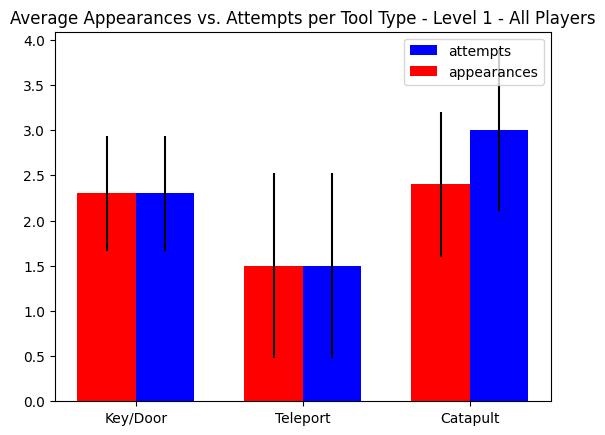

In [549]:
verboseTypes = ['Key/Door', 'Teleport', 'Catapult']
plt.bar(verboseTypes, attempt_means, width=0.35, align='edge', color='blue', yerr=attempt_err, label='attempts')
plt.bar(verboseTypes, appearance_means, width=-0.35, align='edge', color='red', yerr=appearance_err, label='appearances')
plt.title("Average Appearances vs. Attempts per Tool Type - Level 1 - All Players")
plt.legend()

Let's try clustering the data based on the pre-interaction movement patterns in level 1

We'll use level 1 data for 100 participants, and give the leadPathLength, numAllowed, passed, and reactionTime, and then compare these to the tool type

In [973]:
### Set the level for the tests
lvl = 4
mdf1 = mdf.loc[(mdf["level"] == lvl) & (~mdf["layout"].str.contains('test'))]
clusteringDF_init = mdf1.loc[:, mdf1.columns.isin(['leadPathLength', 'numAllowed', 'passed', 'reactionTime', 'toolType'])]
clusteringDF = clusteringDF_init.copy()
clusteringDF.head()

,reactionTime,toolType,passed,leadPathLength,numAllowed
115,0.000,key,1.0,3,3
116,1.636,door,1.0,2,2
117,4.261,catapult,1.0,15,7
118,4.872,teleporter,1.0,11,4
119,0.000,key,0.0,3,3


In [956]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
carr_init = clusteringDF.loc[:, ~clusteringDF.columns.isin(['toolType'])]
carr = carr_init.copy()
carr["reactionTime"] = carr["reactionTime"].map(lambda x: 1 * x / max(carr["reactionTime"]))

In [957]:
# PCA reduce to 2D
reduced = PCA(n_components=2).fit_transform(carr)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init="auto").fit(reduced)

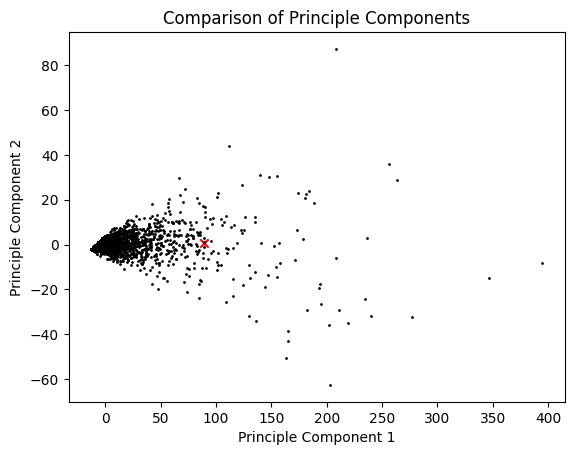

In [958]:
plt.plot(reduced[:, 0], reduced[:, 1], "k.", markersize=2)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.title("Comparison of Principle Components")
plt.show()

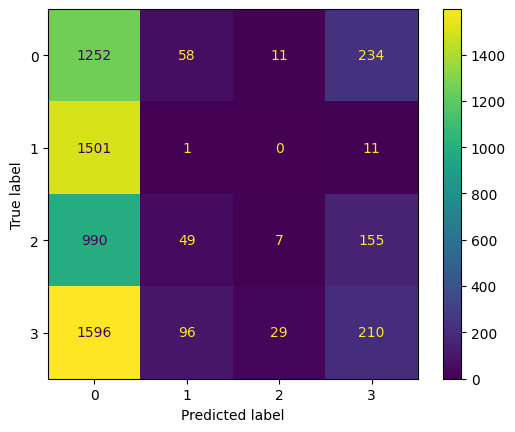

In [959]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
toolTypeMapping = {
    'key' : 0,
    'door' : 1,
    'teleporter' : 2,
    'catapult' : 3
}
kmeans = KMeans(init="k-means++", n_clusters=4, n_init="auto").fit(reduced)
clusteringDF["klabels"] = kmeans.labels_
toolTypeInts = [toolTypeMapping[i] for i in clusteringDF["toolType"]]
cm = confusion_matrix(toolTypeInts, list(clusteringDF["klabels"]))
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [773]:
list(toolTypeMapping.keys())

['key', 'door', 'teleporter', 'catapult']

This doesn't give us much - lets run an ANOVA to see if these are actually statistically significant

In [960]:
from scipy.stats import f_oneway
# Start with lead path
ps = []
# This gives us reaction time for each of the 4 tool types
# We're testing the null hypothesis that there is no relationship between reaction times in the 4 groups
for i in list(toolTypeMapping.keys()):
    ps.append(list(clusteringDF.loc[clusteringDF["toolType"] == i]["reactionTime"]))

f_oneway(ps[0], ps[1], ps[2], ps[3])

F_onewayResult(statistic=49.69013815394279, pvalue=9.987229220687363e-32)

One-Way ANOVA Results - Level 1
===

Testing with leadPathLength, reactionTime, numAllowed:

- leadPathLength: F_onewayResult(statistic=27.720901611713206, pvalue=2.2711083667473537e-17)
- numAllowed: F_onewayResult(statistic=29.910225255513087, pvalue=1.0842876521285245e-18)
- reactionTime: F_onewayResult(statistic=27.39089809230871, pvalue=3.5960045635120174e-17)

One-Way ANOVA Results - Level 2
===

- leadPathLength: F_onewayResult(statistic=31.465892497132696, pvalue=5.3430064852506846e-20)
- numAllowed: F_onewayResult(statistic=34.10528613772016, pvalue=1.2119215530084627e-21)
- reactionTime: F_onewayResult(statistic=21.800797248006706, pvalue=5.932879387412586e-14)

So we can reject the null hypothesis since p << 0.05 for each of these relationships.

In [794]:
no0s = [i+0.1 for i in (list(clusteringDF["reactionTime"]))]

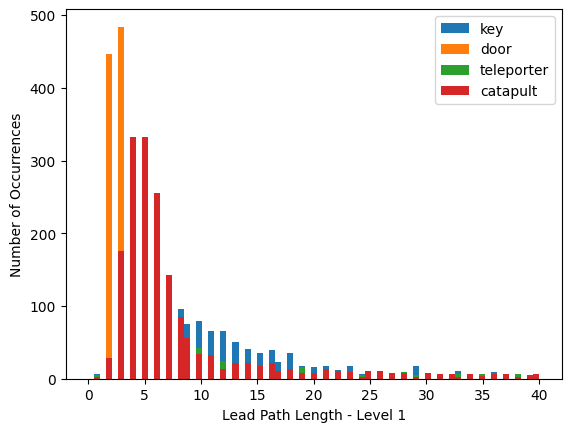

In [961]:
# Params are leadPathLength, numAllowed, and reactionTime
t = "leadPathLength"
for i in list(toolTypeMapping.keys()):
    XX = list(clusteringDF.loc[clusteringDF["toolType"] == i][t])
    plt.hist(XX, bins=75, range=(0, 40), label=i)
plt.xlabel(f'Lead Path Length - Level {lvl}')
plt.ylabel("Number of Occurrences")
plt.legend()
plt.show()

The following shows a histogram of leadPathLength values. It has a modal value of 4, with a long tail that we've cut off at 40.

We could model the main section of this distribution with a Poisson distribution - in this case we'll use an Erlang distribution to try and capture more of the tail.

But why are some players moving around 40 times *before* they even hit the catapult? Since there's no obvious reason for this, it's likely them playing around or not properly focusing. So in theory, the length of this tail should reduce with higher levels, when the players are likely more focused.

As a result, if we cut off the tail, and take the modal value as the input value for randomly sampling an Erlang distribution, we get a shape that's not dissimilar to the observed distribution.

Looking at how many occurences there are of lead path lengths > 20 over the 4 levels, it does indeed reduce from 70 -> 61 -> 55 -> 25 from lvls 1-4

20 occurences above threshold of 20


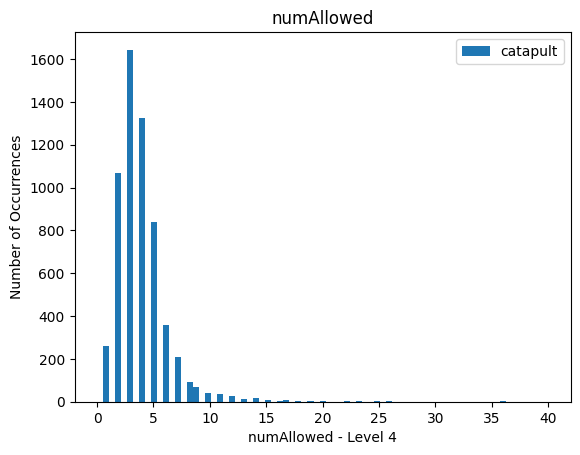

In [982]:
# Let's just look at the leadPathLength for level 2
t = "numAllowed"
XX = list(clusteringDF.loc[clusteringDF["toolType"] == "catapult"][t])
print(sum(i > 20 for i in XX), "occurences above threshold of 20")
# 70, 61, 55, 25
plt.hist(XX, bins=75, range=(0, 40), label="catapult")
plt.title(f'{t}')
plt.xlabel(f'{t} - Level {lvl}')
plt.ylabel("Number of Occurrences")
plt.legend()
plt.show()

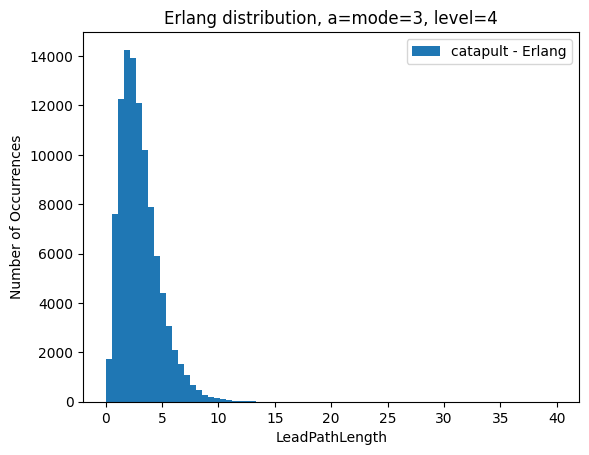

In [984]:
# Let's model the probability of leadPathLength as a Poisson distribution, since it's a set of discrete integers
# Poisson doesn't capture the tail on our data, maybe let's try and Erlang distribution
from scipy.stats import poisson, erlang, mode
r = erlang.rvs(1, size=10)
# get the mean of the leadPathLength for one tool type
lplMean = mode(list(clusteringDF.loc[clusteringDF["toolType"] == "catapult"]["numAllowed"]))[0][0]
plt.hist(erlang.rvs(lplMean, size=100000), bins=75, range=(0, 40), label="catapult - Erlang")
plt.title(f'Erlang distribution, a=mode={lplMean}, level={lvl}')
plt.xlabel("LeadPathLength")
plt.ylabel("Number of Occurrences")
plt.legend()
plt.show()

PCA
---

In [42]:
# PCA
from sklearn.decomposition import PCA

# Data for PCA needs to be a numpy array of the form X = (n_samples, n_features)
# Our features are test, train, and transfer
X = []
Y = list(set(list(nodp_comp["id"])))
for i in list(set(list(nodp_comp["id"]))):
    # Get the equivalent id in the ranked df
    tmp = ranked.loc[ranked["ppt_id"] == i]
    X.append([tmp["train"].iloc[0], tmp["test"].iloc[0], tmp["transfer"].iloc[0]])

In [43]:
# So loop over each participant in nodp_comp, and get their test, train, and transfer values from `ranked`
# and put it in our array
Xin = np.asarray(X)
Yin = np.asarray(Y)

In [40]:
Xin.shape

(7699, 3)

In [77]:
pca = PCA(n_components=3)
pca.fit(X)
o = pca.transform(Xin)

PCA(n_components=3)

In [124]:
import statistics
pca.explained_variance_
statistics.median(Xin[:,2])

0.45

In [128]:
# Also get all the players who had transfer score higher than the median
o_med = []
med = statistics.median(Xin[:, 2])
for ix, j in enumerate(Y):
    if Xin[ix][2] >= med:
        # Get the corresponding principle component value
        o_med.append(o[ix])
        
om = np.asarray(o_med)

In [129]:
om[:, 0]

array([-0.17008839, -0.22914596, -0.50039979, ..., -0.55276776,
       -0.47402295, -0.51627379])

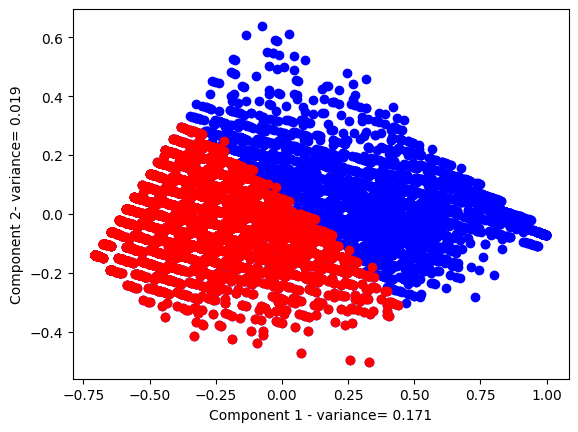

In [130]:
plt.plot(o[:, 0], o[:, 1], 'o', color='blue')
plt.plot(om[:, 0], om[:, 1], 'o', color='red')
plt.xlabel(f'Component 1 - variance= {round(pca.explained_variance_[0], 3)}')
plt.ylabel(f'Component 2- variance= {round(pca.explained_variance_[1], 3)}')
plt.show()

In [159]:
# Let's add the PCA1 scores to nod_comp
nodp_comp.head()
myRanked = {
    "ppt_id" : [Yin[i] for i in range(len(Yin))],
    "train" : [Xin[i][0] for i in range(len(Yin))],
    "test" : [Xin[i][1] for i in range(len(Yin))],
    "transfer": [Xin[i][2] for i in range(len(Yin))],
    "score": [o[:, 0][i] for i in range(len(Yin))]
}

In [204]:
mrdf = pd.DataFrame.from_dict(myRanked).sort_values('score', ascending=True)
mrdf.head()

,ppt_id,train,test,transfer,score,ix
5046,gbj16TrPo6ZhsdajrCfhndeoFxHhQUuvdOS0RgivC222Hj...,1.0,1.0,1.0,-0.704972,5217
7665,3oQzr23UQg4%2B0x4E/urQHa43CdyXs5qZTw1wkqsYdA9y...,1.0,1.0,1.0,-0.704972,7982
2590,%2BlxTxwOWpZE16eKJ3cqh/fcFlryXG6Iny96zbMDt2K35...,1.0,1.0,1.0,-0.704972,2606
3412,DEUI03uImg8i3rHdCohw39eGGH2hAYlL7KxasiUZbuQzxd...,1.0,1.0,1.0,-0.704972,3416
1989,Re18yVqJocEssLhXrRflt6JuogTiplTynjqK7zvf7qxreE...,1.0,1.0,1.0,-0.704972,2047


In [953]:
# And now for each ppt_id here, get the equivalent rank in Mira's
myIx = []
miraIx = []
for ix, i in enumerate(mrdf["ppt_id"]):
    miraIx.append(ranked.index[ranked["ppt_id"] == i][0])
    myIx.append(ix)
#     print(ranked.index[ranked["ppt_id"] == i][0], ix, mrdf.iloc[ix]["ppt_id"])

NameError: name 'mrdf' is not defined

In [215]:
ranked.loc[ranked["ppt_id"] == "gbj16TrPo6ZhsdajrCfhndeoFxHhQUuvdOS0RgivC222Hj5teAE%3D%0A"]

,ppt_id,train,test,transfer,score
34,gbj16TrPo6ZhsdajrCfhndeoFxHhQUuvdOS0RgivC222Hj...,1.0,1.0,1.0,2.70238


In [206]:
mrdf["myIx"] = myIx
mrdf["miraIx"] = miraIx
change = [myIx[i] - miraIx[i] for i in range(len(myIx))]
mrdf["change"] = change
myRanked = mrdf.drop(labels = ["ix", "myIx", "miraIx", "change"], axis=1)
revscore = list(mrdf["score"])[::-1]
mrdf["score"] = revscore
np.arange(0, len(list(myRanked["ppt_id"])))
myRanked.index = np.arange(0, len(list(myRanked["ppt_id"])))
myRanked.to_csv("ranked.csv")